# Hotel Reviews Embedding
In this notebook, we train and evaluate a **doc2vec** model to define vectors in an embedding space for reviews from the [hotel reviews dataset](https://www.kaggle.com/datafiniti/hotel-reviews).

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import string, itertools

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from langdetect import detect
from langdetect import DetectorFactory
from nltk.corpus import stopwords
from scipy import stats
from plots import plot_confusion, plot_tsne

DetectorFactory.seed = 0 # enforce deterministic language detection for short / ambiguous text
random_state = 42

sns.set()
plt.rcParams['figure.figsize'] = (16, 9)

## Read and examine the data

In [2]:
data = pd.read_csv('./data.csv')

In [3]:
data.shape

(35912, 19)

In [4]:
np.max([len(str(x)) for x in (data['reviews.text'] + ' ' + data['reviews.title'])])

3812

In [5]:
list(data.columns.values)

['address',
 'categories',
 'city',
 'country',
 'latitude',
 'longitude',
 'name',
 'postalCode',
 'province',
 'reviews.date',
 'reviews.dateAdded',
 'reviews.doRecommend',
 'reviews.id',
 'reviews.rating',
 'reviews.text',
 'reviews.title',
 'reviews.userCity',
 'reviews.username',
 'reviews.userProvince']

In [6]:
data.head()

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews.date,reviews.dateAdded,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.userCity,reviews.username,reviews.userProvince
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,NaN,Maud,NaN
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN
4,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-03-05T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,������ ���������������,NaN,sungchul,NaN


In [7]:
data['reviews.doRecommend'].value_counts()

Series([], Name: reviews.doRecommend, dtype: int64)

In [8]:
ratings = data['reviews.rating'].value_counts(sort=False).sort_index(ascending=False)

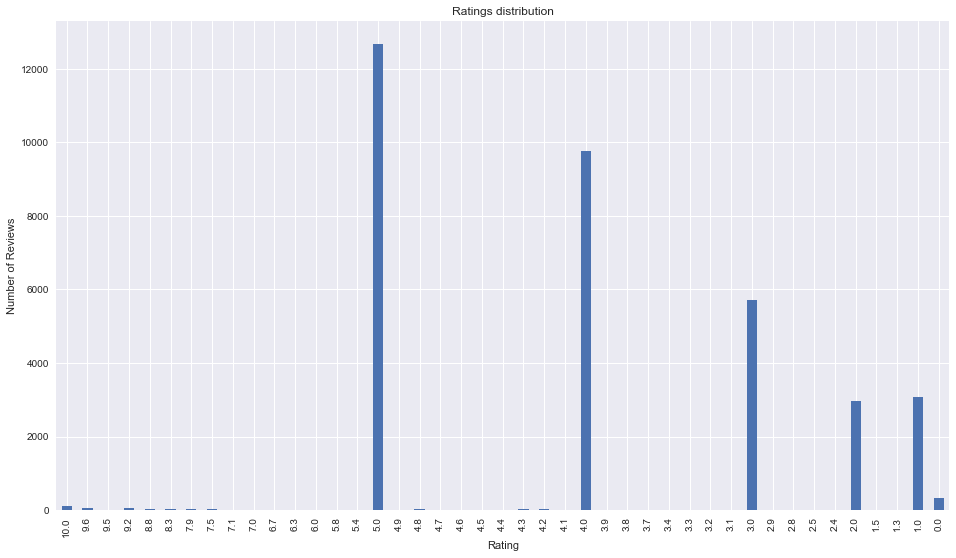

In [9]:
ratings.plot(kind='bar', title='Ratings distribution')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')

## Data cleaning

### Remove dimensions that we will not use
- `reviews.text` + `reviews.title` comprise our input data, $ x $
- `reviews.rating` comprises the ground truth, $ y $.

In [10]:
cleaned = data[['reviews.title', 'reviews.text', 'reviews.rating']].copy()

In [11]:
cleaned.shape

(35912, 3)

In [12]:
cleaned.head()

,reviews.title,reviews.text,reviews.rating
0,Good location away from the crouds,Pleasant 10 min walk along the sea front to th...,4.0
1,Great hotel with Jacuzzi bath!,Really lovely hotel. Stayed on the very top fl...,5.0
2,Lugnt l��ge,Ett mycket bra hotell. Det som drog ner betyge...,5.0
3,Good location on the Lido.,We stayed here for four nights in October. The...,5.0
4,������ ���������������,We stayed here for four nights in October. The...,5.0


### Drop any duplicate reviews
- Considering the `reviews.text` attribute, as we note some exact duplicate review texts above
- Considering the `reviews.title`, since we note reviews with same title above.
    - Some of these may be from different users, however many examples are next to each other in index, so possibly multiple entries from same user? Seems safer to drop them than to attempt a merge

In [13]:
cleaned.drop_duplicates(inplace=True, subset='reviews.text', keep=False)
cleaned.drop_duplicates(inplace=True, subset='reviews.title', keep=False)

In [14]:
cleaned.shape

(16794, 3)

In [15]:
cleaned.head()

,reviews.title,reviews.text,reviews.rating
0,Good location away from the crouds,Pleasant 10 min walk along the sea front to th...,4.0
1,Great hotel with Jacuzzi bath!,Really lovely hotel. Stayed on the very top fl...,5.0
2,Lugnt l��ge,Ett mycket bra hotell. Det som drog ner betyge...,5.0
8,G��nstige Lage,Gnstiger Ausgangspunkt fr Venedig Besuche. Ruh...,3.0
9,Ro og hygge,Lidoen er perfekt til et par dages ro og afsla...,4.0


### Combine the review title and text

In [16]:
cleaned['review'] = cleaned['reviews.title'] + ' ' + cleaned['reviews.text']
cleaned.drop(labels=['reviews.title', 'reviews.text'], inplace=True, axis=1)
cleaned.rename(index=str, columns={'reviews.rating': 'rating'}, inplace=True)

In [17]:
cleaned.head()

,rating,review
0,4.0,Good location away from the crouds Pleasant 10...
1,5.0,Great hotel with Jacuzzi bath! Really lovely h...
2,5.0,Lugnt l��ge Ett mycket bra hotell. Det som dro...
8,3.0,G��nstige Lage Gnstiger Ausgangspunkt fr Vened...
9,4.0,Ro og hygge Lidoen er perfekt til et par dages...


### Drop NaN values
- We will not use data that is incomplete

In [18]:
cleaned = cleaned.dropna()

In [19]:
cleaned.shape

(16726, 2)

### Remove noisy ratings
- Vast majority of ratings are one of {0.0, 1.0, 2.0, 3.0, 4.0, 5.0}.
- Suggests at one point in time the rating scale was 0.0-10.0, but since adjusted to 0-5.
- Therefore, drop any rows with ratings that are not in {0.0, 1.0, 2.0, 3.0, 4.0, 5.0}

In [20]:
cleaned = cleaned[cleaned['rating'].isin([0.0, 1.0, 2.0, 3.0, 4.0, 5.0])]

In [21]:
cleaned.shape

(16450, 2)

In [22]:
cleaned['rating'].value_counts()

5.0    6070
4.0    4669
3.0    2686
1.0    1530
2.0    1495
Name: rating, dtype: int64

Interestingly, no 0.0 values remain, perhaps dropped by earlier processing steps.

### Clean the text
- We must lowercase all reviews so that the model is invarient to case
- Remove punctuation and invalid characters

In [23]:
def clean_text(text):
    return text.replace('�', '').lower().translate(str.maketrans('', '', string.punctuation)).strip()

In [24]:
cleaned['review'] = cleaned['review'].apply(clean_text)

### Remove non-English reviews
- For simplicity, in this example we will only consider reviews in one language

In [25]:
def exception_safe_detect(s):
    try:
        return detect(s)
    except:
        return ''

In [26]:
cleaned = cleaned[cleaned['review'].apply(exception_safe_detect) == 'en']

In [27]:
cleaned.shape

(15612, 2)

In [28]:
# Last chance to remove dupes before tokenizing, since lists are unhashable
cleaned.drop_duplicates(inplace=True, keep=False, subset='review')

In [29]:
cleaned.shape

(15600, 2)

### Tokenise the reviews
In order to train the doc2vec model, the reviews must be tokenised into a list of strings.

In [30]:
cleaned['review'] = cleaned['review'].str.split()

In [31]:
cleaned.head()

,rating,review
0,4.0,"[good, location, away, from, the, crouds, plea..."
1,5.0,"[great, hotel, with, jacuzzi, bath, really, lo..."
11,3.0,"[it, was, ok, hotel, is, nice, from, in, and, ..."
16,4.0,"[nice, hotel, with, very, friendly, and, helpf..."
20,1.0,"[dungeons, drain, flies, and, centipedes, dont..."


### Remove stopwords
Remove commonly used words such as 'the', 'to', 'from', etc.

In [32]:
stopWords = set(stopwords.words('english'))

In [33]:
def clean_stopwords(tokens, stopWords):
    ret = []
    for t in tokens:
        if t not in stopWords:
            ret.append(t)
    
    return ret

In [34]:
cleaned['review'] = cleaned['review'].apply(clean_stopwords, args=(stopWords,))

## Train model
First, we will split the cleaned data into train and test sets, and use these to fit and evaluate a doc2vec model.

In [35]:
x_train, x_test, y_train, y_test = train_test_split(
    cleaned['review'], cleaned['rating'], test_size=0.2, random_state=random_state)

In [36]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(x_train)]

In [37]:
model = Doc2Vec(vector_size=50, min_count=2, epochs=40)

In [38]:
model.build_vocab(documents)

In [39]:
%time model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 40.6 s, sys: 8.13 s, total: 48.7 s
Wall time: 26.1 s


### Sanity check
Check the similarity ranks for documents from the training set. If the model is working properly, the query document should be ranked 0th in the similarity results.

In [40]:
ranks = []

for i in range(len(x_train)):
    inferred_vector = model.infer_vector(x_train.iloc[i])
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    ranks.append([docid for docid, _ in sims].index(i))

/Users/rtjfarrimond/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


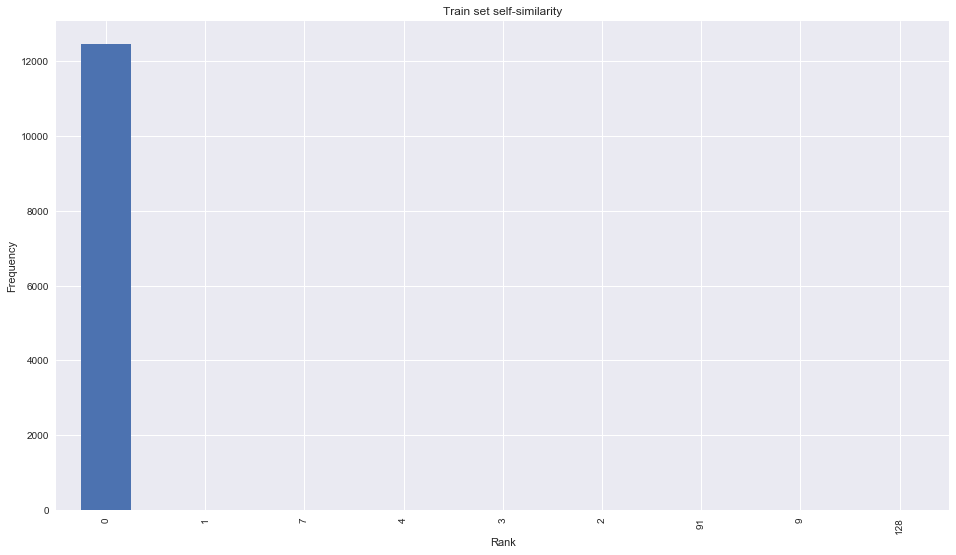

In [41]:
pd.Series(ranks).value_counts().plot('bar')
plt.title('Train set self-similarity')
plt.xlabel('Rank')
plt.ylabel('Frequency')

## Evaluate the model
We will evaluate our doc2vec model by defining a prediction $ \hat{y} $ to be the modal rating for the 10 most similar results to each document in the train and test sets, i.e. knn. Once we have computed $ \hat{y} $, we will compare how it compares with the ground truth by visualising a confusion matrix.

In [42]:
def inspect_ratings(x, y, docvec_labels, k='root_n'):
    ratings = {}
    if k == 'root_n':
        k=int(np.sqrt(len(x)))
    
    for i in range(len(x)):
        inferred_vector = model.infer_vector(x.iloc[i])
        rating = [docvec_labels[idx] for idx, _ in model.docvecs.most_similar([inferred_vector], topn=k)]
        ratings[i] = rating
        
    conf_mat = confusion_matrix(y.values, [stats.mode(v)[0][0] for v in ratings.values()])
        
    return ratings, conf_mat

/Users/rtjfarrimond/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


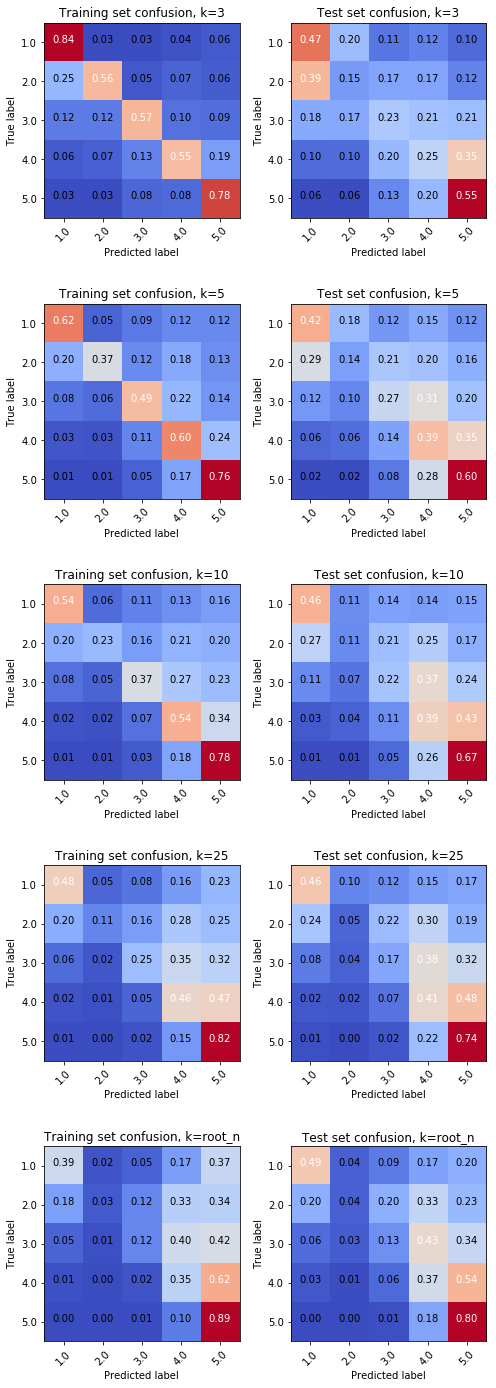

In [43]:
sns.reset_orig()
nn = [3, 5, 10, 25, 'root_n']

plt.figure(figsize=(7,20))

for i, k in enumerate(nn):
    _, train_conf = inspect_ratings(x_train, y_train, y_train, k)
    _, test_conf = inspect_ratings(x_test, y_test, y_train, k)

    plt.subplot(len(nn),2,(i)*2+1)
    plot_confusion(train_conf, np.unique(y_train), normalize=True, title='Training set confusion, k={}'.format(k))
    plt.subplot(len(nn),2,(i+1)*2)
    plot_confusion(test_conf, np.unique(y_test), normalize=True, title='Test set confusion, k={}'.format(k))

We see from above that as we increase $ k $, that is the number of neighbours we examine to produce $ \hat{y} $, then the accuracy for rating 5 increases, whilst accuracy for all other ratings decrease, largely due to making misclassifications by predicting a 5 rating. Conversely, by decreasing $ k $, we see accuracy increase for other ratings - particularly for 1 - but decreasing for 5.0. We can see why this is the case by referring to the rating distribution historgrams plotted below, where we note that 5.0 is by far the most frequent review score in this data. It makes sense therefore, that as we increase $ k $ we will retrieve more documents rated 5, if ratings are not well clustered and separated in the feature space.

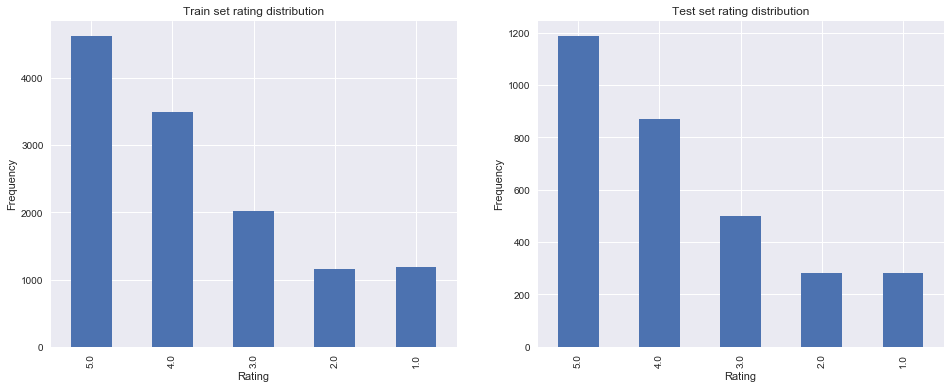

In [44]:
sns.set()

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
y_train.value_counts(sort=False).sort_index(ascending=False).plot(kind='bar', title='Train set rating distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.subplot(1,2,2)
y_test.value_counts(sort=False).sort_index(ascending=False).plot(kind='bar', title='Test set rating distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')

## Visualise the embedding space
We now compute a t-SNE embedding to visualise the embedding space to examine the clustering. We expect from our above observation, made when modulating the size of $ k $ in knn, to see poor seperation of clusters.

In [45]:
t_sne = TSNE(n_components=2, init='pca', random_state=random_state, perplexity=28)

In [46]:
embedding = t_sne.fit_transform([model.docvecs[x] for x in range(len(model.docvecs))])

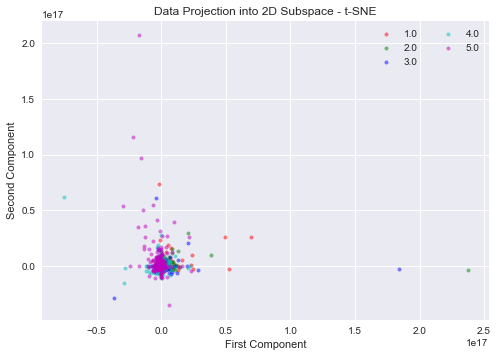

In [47]:
plot_tsne(embedding, y_train)

## Save the model

In [48]:
model.save('doc2vec.mdl')

## Closing notes
Since we now have a model that we can use to convert reviews to vectors in the embedding space, and since the quality of the vectors is not of great importance to this exercise, we will stop here. Despite the proclivity to mis-classify ratings as 5.0, the model does also have a fair accuracy for classifying 1.0 ratings, indicating that as a binary classifier for positive and negative reviews this model is showing promise. If we were to iterate on this model to improve its performance I would consider making the following adjustments:

- Change the cardinality of the classification problem from 5 to 3 to make it easier to compare with human level performance
    - by binning: { positive (5 & 4), negative (1 & 2), neutral (3) }
    - Evaluate on categorical F1 score rather than accuracy
- Flatten the distribution in the training set
- Experiment using different hyper-parameters to tune the doc2vec model
- Transform the embedding space using PCA to align the data distribution with the latent semantic vectors before evalutaing on the classification task
- Inspect the number of natural clusters in the embedding space